# Explicação:
Nesse arquivo há:
 - Junção e análise dos dados em catálogo usados para a tarefa de pré-treino.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
total = pd.concat([pd.read_csv(f"raw_tables/result{i}.csv") for i in range(1,9)])

In [5]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(total,test_size=0.25,random_state=2)
test = test.assign(test=1, train=0, validation=0, split="test")
train = train.assign(test=0)
train,val = train_test_split(train,test_size=0.2,random_state=2)
train = train.assign(train=1, validation=0, split="train")
val = val.assign(train=0, validation=1, split="val")
final = pd.concat([train,test,val])

## Análise da distribuição de magnitude:

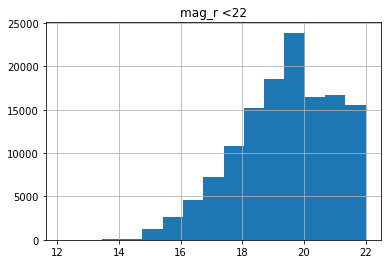

In [8]:
plt.title("mag_r <22")
final.r_iso.hist(bins=15)

In [9]:
print(f"Existem {len(final[final.r_iso<=14])} objetos com magnitude <= 14")
for i in range(15,23):
    print(f"Existem {len(final[(final.r_iso>i-1)&(final.r_iso<=i)])} objetos com magnitude {i-1}<r<={i}")

Existem 98 objetos com magnitude <= 14
Existem 200 objetos com magnitude 14<r<=15
Existem 3308 objetos com magnitude 15<r<=16
Existem 7327 objetos com magnitude 16<r<=17
Existem 14803 objetos com magnitude 17<r<=18
Existem 24564 objetos com magnitude 18<r<=19
Existem 33546 objetos com magnitude 19<r<=20
Existem 27330 objetos com magnitude 20<r<=21
Existem 21955 objetos com magnitude 21<r<=22


## Salvando em csv:

In [10]:
final.reset_index().drop(columns='index').to_csv("unl.csv")